to do:


1. change visualization style
2. change variable names


### Setup

In [ ]:
# Ignore warnings :
import warnings
warnings.filterwarnings('ignore')


# Handle table-like data and matrices :
import numpy as np
import pandas as pd
import math 
import itertools

# Modelling Helpers :
from sklearn.preprocessing import Normalizer , scale
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score



# Evaluation metrics :

# Regression
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 

# Classification
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score


# Deep Learning Libraries
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical


# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
# import missingno as msno


# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

In [2]:
# Center all plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");


# Make Visualizations better
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plt.rcParams.update(params)

### 1. Exploring the dataset

In [3]:
import os
print(os.listdir('./data/'))

ratings = pd.read_csv('./data/ratings.csv')
movies = pd.read_csv('./data/movies.csv')
df_r = ratings.copy()
df_m = movies.copy()

ratings.head()

['links.csv', 'tags.csv', 'ratings.csv', 'README.txt', 'movies.csv']


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
ratings.shape
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [5]:
ratings.drop(['timestamp'], axis=1, inplace=True)
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [6]:
movies.head()
print('Shape: ', movies.shape, '\n')
movies.info()

Shape:  (9742, 3) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [7]:
df_combined = pd.merge(ratings, movies, on = 'movieId')
print(df_combined.head())
print(df_combined.shape)

   userId  movieId  rating             title  \
0       1        1     4.0  Toy Story (1995)   
1       5        1     4.0  Toy Story (1995)   
2       7        1     4.5  Toy Story (1995)   
3      15        1     2.5  Toy Story (1995)   
4      17        1     4.5  Toy Story (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1  Adventure|Animation|Children|Comedy|Fantasy  
2  Adventure|Animation|Children|Comedy|Fantasy  
3  Adventure|Animation|Children|Comedy|Fantasy  
4  Adventure|Animation|Children|Comedy|Fantasy  
(100836, 5)


In [8]:
# Create a function to find genres in the dataset

genres = {} 
def find_genres():
    for genre in movies['genres']:
        words = genre.split('|')
        for word in words:
            genres[word] = genres.get(word, 0) + 1
            
find_genres()

In [9]:
genres

{'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Fantasy': 779,
 'Romance': 1596,
 'Drama': 4361,
 'Action': 1828,
 'Crime': 1199,
 'Thriller': 1894,
 'Horror': 978,
 'Mystery': 573,
 'Sci-Fi': 980,
 'War': 382,
 'Musical': 334,
 'Documentary': 440,
 'IMAX': 158,
 'Western': 167,
 'Film-Noir': 87,
 '(no genres listed)': 34}

In [10]:
# heavily rated movies
df_n_ratings = pd.DataFrame(df_combined.groupby('title')['rating'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(df_combined.groupby('title')['rating'].count())
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)

df_n_ratings.sort_values('total ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278
Star Wars: Episode IV - A New Hope (1977),4.231076,251
Jurassic Park (1993),3.750000,238
Braveheart (1995),4.031646,237
Terminator 2: Judgment Day (1991),3.970982,224


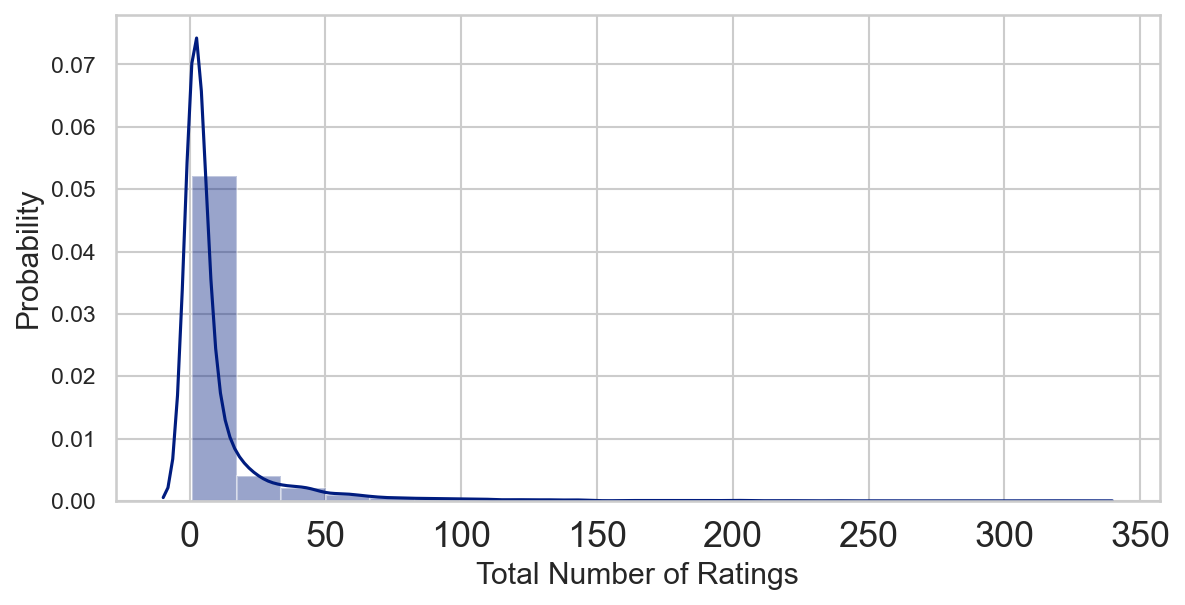

In [11]:
plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['total ratings'], bins=20)
plt.xlabel('Total Number of Ratings')
plt.ylabel('Probability')
plt.show()

In [12]:
df_n_ratings.sort_values('mean ratings', ascending=False)

print('Total no of users that gave rating of 5.0 : ', 
      len(df_n_ratings.loc[df_n_ratings['mean ratings'] == 5]), '\n')
print('Total no of Individual users that gave rating of 5.0 : ', 
      len(df_n_ratings.loc[(df_n_ratings['mean ratings'] == 5) 
         & (df_n_ratings['total ratings'] == 1)]))

Total no of users that gave rating of 5.0 :  296 

Total no of Individual users that gave rating of 5.0 :  289


### Collaborative Filtering

In [13]:
# user-item matrix
util_mat = df_combined.pivot_table(index = 'userId', 
                                   columns = 'title', values = 'rating')
util_mat.head(20)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [14]:
user_util_matrix = util_mat.copy()
# We will fill the row wise NaN's with the corresponding user's mean ratings, so that we can carry out Pearson correlation.
# Here we assume avg ratings for the movie that is not rated.
user_util_matrix = user_util_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)
user_util_matrix.head(5)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,...,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.000000,4.366379
2,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,...,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276
3,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,...,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897
4,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,...,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556
5,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,...,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364


In [15]:
user_corr_mat = user_util_matrix.T.corr()


In [16]:
# For convinience, I will be be considering only the correlation of all users with the first user only.
corr_user_1 = user_corr_mat.iloc[0]
corr_user_1.sort_values(ascending=False, inplace=True)
corr_user_1

userId
1      1.000000
301    0.124799
597    0.102631
414    0.101348
477    0.099217
         ...   
71    -0.082932
370   -0.086678
501   -0.090018
579   -0.105003
53          NaN
Name: 1, Length: 610, dtype: float64

In [17]:
# NaN values are generated in corr() as the std dev is zero, 
# which is required in calculating Pearson Similarity.
corr_user_1.dropna(inplace = True)

# Neglect the 1st corr value as it is user1 itself
top50_corr_users = corr_user_1[1:51]

In [18]:
# the list of all movies that user 1 has ever rated.

df_combined[ df_combined['userId'] == 1]

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
215,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
267,1,6,4.0,Heat (1995),Action|Crime|Thriller
369,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
572,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...
16056,1,3744,4.0,Shaft (2000),Action|Crime|Thriller
16075,1,3793,5.0,X-Men (2000),Action|Adventure|Sci-Fi
16208,1,3809,4.0,What About Bob? (1991),Comedy
16243,1,4006,4.0,Transformers: The Movie (1986),Adventure|Animation|Children|Sci-Fi


In [19]:
# user1 has not rated movieid 32
df_combined[ (df_combined['userId'] == 1) & (df_combined['movieId'] == 32) ] 

,userId,movieId,rating,title,genres


In [20]:
print('32nd Movie : ', movies['title'][ movies['movieId'] == 32 ].values)

32nd Movie :  ['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']


In [21]:
#let's calculate what ratings user 1 would give to the movie with the help of similarity vector. 
# And based on that rating, we can compare it with a threshold rating. 
# If the rating is higher it will be visible to the active user in his/her recommended list.
df_n_ratings.loc[['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']]

,mean ratings,total ratings
title,,
Twelve Monkeys (a.k.a. 12 Monkeys) (1995),3.983051,177


In [22]:
top50_users = top50_corr_users.keys()

count = 0
users = list()
for user in top50_users:
    if df_combined[ (df_combined['userId'] == user) & (df_combined['movieId'] == 32) ]['rating'].sum()  :
        count +=1
        users.append(user)

print(count)

30


There are 30 similar users among the Top-50 similar users that have rated the movie "The Twelve Monkeys".
Now, let's calculate the rating user 1 would give to the movie,

Predicted rating = sum of [ (weights) * (ratings) ] / sum of (weights)

Here, weights is the correlation of the corresponding user with the first user.

In [23]:
# Let's define a function to calculate what user1 will rate the movie
# We use Weighted average of k similar users (weighted KNN)

def predict_rating():
    sum_similarity = 0
    weighted_ratings = 0
    for user in users:
        weighted_ratings += top50_corr_users.loc[user] * df_combined[ (df_combined['userId'] == user) & 
                                                              (df_combined['movieId'] == 32) ]['rating'].sum()
        sum_similarity += top50_corr_users.loc[user]

    print(weighted_ratings / sum_similarity)
    
    
predict_rating()

4.136895301597431


#### item-based CF

In [24]:
item_util_matrix = util_mat.copy()

# We will fill the column wise NaN's with the corresponding movie's mean ratings, 
# so that we can carry out Pearson correlation.
# Here we assume avg ratings for the user that has not a rated movie.

item_util_matrix = item_util_matrix.apply(lambda col : col.fillna(col.mean()), axis=0)
item_util_matrix.head(5)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,4.000000,1.0
2,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
3,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
4,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
5,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0


In [25]:
item_util_matrix.isna().sum().sum()

0

This signifies that every Movie is rated by atleast 1 user.

In [26]:
item_util_matrix.corr()
# 1m 36.3s 

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,1.000000e+00,NaN,-2.470732e-17,NaN,-6.780112e-16,-4.090480e-16,...,NaN,1.491461e-15,-2.970631e-18,NaN,NaN,-1.174129e-16,-4.645797e-16,-1.457542e-15,2.833399e-15,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),NaN,NaN,NaN,NaN,-1.174129e-16,NaN,6.069910e-02,NaN,-7.527708e-02,2.947366e-02,...,NaN,-1.446864e-15,-3.198002e-16,NaN,NaN,1.000000e+00,3.784587e-02,1.243837e-15,-3.410933e-02,NaN
xXx (2002),NaN,NaN,NaN,NaN,-4.645797e-16,NaN,-3.527098e-03,NaN,1.558884e-01,2.511177e-01,...,NaN,-2.067568e-01,-4.854206e-03,NaN,NaN,3.784587e-02,1.000000e+00,2.449296e-01,1.854832e-02,NaN
xXx: State of the Union (2005),NaN,NaN,NaN,NaN,-1.457542e-15,NaN,6.026336e-16,NaN,1.107823e-01,-1.311520e-15,...,NaN,-2.014024e-01,7.715167e-02,NaN,NaN,1.243837e-15,2.449296e-01,1.000000e+00,1.064764e-15,NaN


There are lot of NaN values and that is because when we are calculating the Pearson correlation, if the rating vector has all the values same for eg -> [3.0 , 3.0, 3.0, 3.0, ....], then the Standard Deviation is zero and division by zero is undefined, and thus its correlation with any other rating vector is NaN.

Since there are many movies that are rated only by 1 user , there the whole column mean is filled with the rating of that user, and therefore it's Pearson correlation gives NaN values with any other column.

原码只计算了item to item correlation matrix, 然后针对一个电影把similarity score排了个序，没有做完推荐系统

## Model-Based CF

In [27]:
from surprise import Reader, Dataset, KNNBasic
from surprise.model_selection import train_test_split, GridSearchCV
from surprise.accuracy import rmse



#### KNN

calculate the similarity between users (or items) based on their interactions (e.g., ratings of movies). It identifies the nearest neighbors (most similar users or items) and uses their information to make predictions.

In [28]:
from surprise import Reader, Dataset, KNNBasic
from surprise.model_selection import GridSearchCV
from surprise.accuracy import rmse
from surprise import Trainset
import pandas as pd
from sklearn.model_selection import train_test_split
import tracemalloc
# Start memory tracking
tracemalloc.start()

# Load and define the dataset
reader = Reader(rating_scale=(0.5, 5.0))

# Convert ratings DataFrame to raw ratings list
raw_ratings = ratings[['userId', 'movieId', 'rating']].values.tolist()

# Split raw data into training+validation and test sets using sklearn's train_test_split
train_val_raw, test_raw = train_test_split(raw_ratings, test_size=0.2, random_state=42)

# Further split train_val_raw into training and validation sets
train_raw, val_raw = train_test_split(train_val_raw, test_size=0.25, random_state=42)  # 20% of 80% = 16% for validation

# Convert raw splits to Surprise Trainset/Testset formats
# Trainset for training
trainset = Dataset.load_from_df(
    pd.DataFrame(train_raw, columns=["userId", "movieId", "rating"]), reader
).build_full_trainset()

# Validation set (Surprise Testset format)
valset = [
    (uid, iid, float(rating))
    for uid, iid, rating in val_raw
]

# Test set (Surprise Testset format)
testset = [
    (uid, iid, float(rating))
    for uid, iid, rating in test_raw
]

# Define similarity options
sim_options = {'name': 'msd'}

# Define parameter grid for hyperparameter tuning
param_grid = {'k': [10, 20, 30]}

# Perform GridSearchCV for hyperparameter tuning on training set
gs = GridSearchCV(KNNBasic, param_grid=param_grid, measures=['rmse'], cv=5)
gs.fit(Dataset.load_from_df(
    pd.DataFrame(train_val_raw, columns=["userId", "movieId", "rating"]), reader
))

# Best hyperparameters and score from tuning
print('\n\n###############')
print('Best RMSE on Validation: ', gs.best_score['rmse'])
print('Best Parameters: ', gs.best_params['rmse'])
print('###############')


# Train the best model on the full training+validation set
train_valset = Dataset.load_from_df(
    pd.DataFrame(train_val_raw, columns=["userId", "movieId", "rating"]), reader
).build_full_trainset()

best_algo = gs.best_estimator['rmse']
best_algo.fit(train_valset)  # Re-train the best model

# Evaluate on the validation set
val_predictions = best_algo.test(valset)
val_rmse = rmse(val_predictions, verbose=True)

print('\nValidation RMSE: ', val_rmse)

# Evaluate on the test set
test_predictions = best_algo.test(testset)
test_rmse = rmse(test_predictions, verbose=True)

print('\nTest RMSE: ', test_rmse)
# 1.6s

# Stop memory tracking
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Current memory usage: {current / 1024 / 1024:.2f} MB")
print(f"Peak memory usage: {peak / 1024 / 1024:.2f} MB")

#37.1s

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

#### SVD

In [29]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split, cross_validate
from surprise.accuracy import rmse
import pandas as pd
from sklearn.model_selection import train_test_split as sklearn_split
import tracemalloc

# Start memory tracking
tracemalloc.start()

# Load and define the dataset
reader = Reader(rating_scale=(0.5, 5.0))

# Convert ratings DataFrame to raw ratings list
raw_ratings = ratings[['userId', 'movieId', 'rating']].values.tolist()

# Split raw data into training+validation and test sets using sklearn's train_test_split
train_val_raw, test_raw = sklearn_split(raw_ratings, test_size=0.2, random_state=42)

# Further split train_val_raw into training and validation sets
train_raw, val_raw = sklearn_split(train_val_raw, test_size=0.25, random_state=42)  # 20% of 80% = 16% for validation

# Convert raw splits to Surprise Dataset
data = Dataset.load_from_df(pd.DataFrame(train_val_raw, columns=["userId", "movieId", "rating"]), reader)
trainset = Dataset.load_from_df(pd.DataFrame(train_raw, columns=["userId", "movieId", "rating"]), reader).build_full_trainset()

# Validation and test sets
valset = [(uid, iid, float(rating)) for uid, iid, rating in val_raw]
testset = [(uid, iid, float(rating)) for uid, iid, rating in test_raw]

# Cross-validation to evaluate SVD
print("Performing cross-validation with SVD...")
cv_results = cross_validate(algo=SVD(), data=data, measures=['RMSE'], cv=5, verbose=True)

# Train the SVD model on the full train+validation dataset
algo = SVD()
algo.fit(trainset)

# Evaluate on validation set
val_predictions = algo.test(valset)
val_rmse = rmse(val_predictions, verbose=True)
print("\nValidation RMSE: ", val_rmse)

# Evaluate on test set
test_predictions = algo.test(testset)
test_rmse = rmse(test_predictions, verbose=True)
print("\nTest RMSE: ", test_rmse)

# Stop memory tracking
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Current memory usage: {current / 1024 / 1024:.2f} MB")
print(f"Peak memory usage: {peak / 1024 / 1024:.2f} MB")

# 12.4s

Performing cross-validation with SVD...
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8777  0.8881  0.8716  0.8803  0.8787  0.8793  0.0053  
Fit time          0.66    1.04    1.07    1.08    1.13    0.99    0.17    
Test time         0.19    0.22    0.23    0.24    0.23    0.22    0.02    
RMSE: 0.8760

Validation RMSE:  0.8760405681850529
RMSE: 0.8931

Test RMSE:  0.8931007914304068
Current memory usage: 63.84 MB
Peak memory usage: 72.72 MB


#### NMF

In [30]:
from surprise import Reader, Dataset, NMF
from surprise.model_selection import train_test_split, cross_validate
from surprise.accuracy import rmse
import pandas as pd
from sklearn.model_selection import train_test_split as sklearn_split
import tracemalloc

# Start memory tracking
tracemalloc.start()

# Load and define the dataset
reader = Reader(rating_scale=(0.5, 5.0))

# Convert ratings DataFrame to raw ratings list
raw_ratings = ratings[['userId', 'movieId', 'rating']].values.tolist()

# Split raw data into training+validation and test sets using sklearn's train_test_split
train_val_raw, test_raw = sklearn_split(raw_ratings, test_size=0.2, random_state=42)

# Further split train_val_raw into training and validation sets
train_raw, val_raw = sklearn_split(train_val_raw, test_size=0.25, random_state=42)  # 20% of 80% = 16% for validation

# Convert raw splits to Surprise Dataset
data = Dataset.load_from_df(pd.DataFrame(train_val_raw, columns=["userId", "movieId", "rating"]), reader)
trainset = Dataset.load_from_df(pd.DataFrame(train_raw, columns=["userId", "movieId", "rating"]), reader).build_full_trainset()

# Validation and test sets
valset = [(uid, iid, float(rating)) for uid, iid, rating in val_raw]
testset = [(uid, iid, float(rating)) for uid, iid, rating in test_raw]

# Cross-validation to evaluate NMF
print("Performing cross-validation with NMF...")
cv_results = cross_validate(algo=NMF(), data=data, measures=['RMSE'], cv=5, verbose=True)

# Train the NMF model on the full train+validation dataset
algo = NMF()
algo.fit(trainset)

# Evaluate on validation set
val_predictions = algo.test(valset)
val_rmse = rmse(val_predictions, verbose=True)
print("\nValidation RMSE: ", val_rmse)

# Evaluate on test set
test_predictions = algo.test(testset)
test_rmse = rmse(test_predictions, verbose=True)
print("\nTest RMSE: ", test_rmse)

# Stop memory tracking
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Current memory usage: {current / 1024 / 1024:.2f} MB")
print(f"Peak memory usage: {peak / 1024 / 1024:.2f} MB")


# 36.5s

Performing cross-validation with NMF...
Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9239  0.9425  0.9286  0.9302  0.9336  0.9318  0.0062  
Fit time          5.13    5.09    4.92    4.96    4.96    5.01    0.08    
Test time         0.17    0.17    0.17    0.17    0.18    0.17    0.00    
RMSE: 0.9332

Validation RMSE:  0.9332099095709252
RMSE: 0.9428

Test RMSE:  0.9428481951266099
Current memory usage: 58.13 MB
Peak memory usage: 67.11 MB


#### User-based and Item-based CF

In [31]:
from surprise import Reader, Dataset, KNNBasic
from surprise.model_selection import GridSearchCV, cross_validate
from surprise.accuracy import rmse
import pandas as pd
from sklearn.model_selection import train_test_split as sklearn_split
import tracemalloc

# Start memory tracking
tracemalloc.start()

# Load and define the dataset
reader = Reader(rating_scale=(0.5, 5.0))
raw_ratings = ratings[['userId', 'movieId', 'rating']].values.tolist()
train_val_raw, test_raw = sklearn_split(raw_ratings, test_size=0.2, random_state=42)
train_raw, val_raw = sklearn_split(train_val_raw, test_size=0.25, random_state=42)
trainset = Dataset.load_from_df(pd.DataFrame(train_raw, columns=["userId", "movieId", "rating"]), reader).build_full_trainset()
valset = [(uid, iid, float(rating)) for uid, iid, rating in val_raw]
testset = [(uid, iid, float(rating)) for uid, iid, rating in test_raw]

# User-based similarity options
user_based_sim_options = {
    'name': 'pearson',  # Pearson correlation
    'user_based': True  # User-based filtering
}

# Hyperparameter tuning for k using GridSearchCV
param_grid = {'k': [5, 10, 20, 30, 50]}
# Perform grid search without 'sim_options' in the constructor
grid_user = GridSearchCV(
    KNNBasic,
    param_grid=param_grid,
    measures=['rmse'],
    cv=5
)

# Fit GridSearchCV with train_val_raw
data = Dataset.load_from_df(pd.DataFrame(train_val_raw, columns=["userId", "movieId", "rating"]), reader)
grid_user.fit(data)

# Best hyperparameters and RMSE
print("\nBest User-Based Parameters: ", grid_user.best_params['rmse'])
print("Best User-Based RMSE: ", grid_user.best_score['rmse'])

# Train with best parameters
user_algo = KNNBasic(k=grid_user.best_params['rmse']['k'], sim_options=user_based_sim_options)
user_algo.fit(trainset)

# Evaluate on validation set
user_val_predictions = user_algo.test(valset)
user_val_rmse = rmse(user_val_predictions, verbose=True)
print("\nUser-Based Validation RMSE: ", user_val_rmse)

# Evaluate on test set
user_test_predictions = user_algo.test(testset)
user_test_rmse = rmse(user_test_predictions, verbose=True)
print("\nUser-Based Test RMSE: ", user_test_rmse)

# Stop memory tracking
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"User-Based Current memory usage: {current / 1024 / 1024:.2f} MB")
print(f"User-Based Peak memory usage: {peak / 1024 / 1024:.2f} MB")

# 54.2s

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [32]:
from surprise import Reader, Dataset, KNNBasic
from surprise.model_selection import GridSearchCV, cross_validate
from surprise.accuracy import rmse
import pandas as pd
from sklearn.model_selection import train_test_split as sklearn_split
import tracemalloc

# Start memory tracking
tracemalloc.start()

# Load and define the dataset
reader = Reader(rating_scale=(0.5, 5.0))
raw_ratings = ratings[['userId', 'movieId', 'rating']].values.tolist()
train_val_raw, test_raw = sklearn_split(raw_ratings, test_size=0.2, random_state=42)
train_raw, val_raw = sklearn_split(train_val_raw, test_size=0.25, random_state=42)
trainset = Dataset.load_from_df(pd.DataFrame(train_raw, columns=["userId", "movieId", "rating"]), reader).build_full_trainset()
valset = [(uid, iid, float(rating)) for uid, iid, rating in val_raw]
testset = [(uid, iid, float(rating)) for uid, iid, rating in test_raw]

# Item-based similarity options
item_based_sim_options = {
    'name': 'pearson',  # Pearson correlation
    'user_based': False  # Item-based filtering
}

# Hyperparameter tuning for k using GridSearchCV
param_grid = {'k': [5, 10, 20, 30, 50]}

# Perform grid search without 'sim_options' in the constructor
grid_item = GridSearchCV(
    KNNBasic,
    param_grid=param_grid,
    measures=['rmse'],
    cv=5
)

# Fit GridSearchCV with train_val_raw
data = Dataset.load_from_df(pd.DataFrame(train_val_raw, columns=["userId", "movieId", "rating"]), reader)
grid_item.fit(data)

# Best hyperparameters and RMSE
print("\nBest Item-Based Parameters: ", grid_item.best_params['rmse'])
print("Best Item-Based RMSE: ", grid_item.best_score['rmse'])

# Train with best parameters
item_algo = KNNBasic(k=grid_item.best_params['rmse']['k'], sim_options=item_based_sim_options)
item_algo.fit(trainset)

# Evaluate on validation set
item_val_predictions = item_algo.test(valset)
item_val_rmse = rmse(item_val_predictions, verbose=True)
print("\nItem-Based Validation RMSE: ", item_val_rmse)

# Evaluate on test set
item_test_predictions = item_algo.test(testset)
item_test_rmse = rmse(item_test_predictions, verbose=True)
print("\nItem-Based Test RMSE: ", item_test_rmse)

# Stop memory tracking
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Item-Based Current memory usage: {current / 1024 / 1024:.2f} MB")
print(f"Item-Based Peak memory usage: {peak / 1024 / 1024:.2f} MB")

# 1m 16.6s

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

item-based CF is much more memory consuming, because in this case there are much more items and users

### MF using DL

In [ ]:
from keras.layers import Embedding, Input, dot, concatenate
from keras.models import Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import tracemalloc

In [34]:
# The number of latent factors for the embedding
n_latent_factors = 50

# Re-index userId and movieId to ensure they are consecutive integers
ratings['userId'], user_map = pd.factorize(ratings['userId'])
ratings['movieId'], movie_map = pd.factorize(ratings['movieId'])

# Update n_users and n_movies
n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()

# no of users and movies
# n_users, n_movies = len(ratings['userId'].unique()), len(ratings['movieId'].unique()) 

In [39]:
# Splitting Data into Train and Validation Set¶
X = ratings.iloc[:,:2]
Y = ratings.iloc[:,2]

x_train, x_test, y_train, y_test = sklearn_split(X, Y, test_size = 0.2, random_state = 66)

In [ ]:
# print(n_users)
# print(n_movies)

610
9724


In [ ]:
# # Validate userId
# invalid_users = x_train['userId'][x_train['userId'] >= n_users]
# if not invalid_users.empty:
#     print("Invalid user IDs found:", invalid_users)

# # Validate movieId
# invalid_movies = x_train['movieId'][x_train['movieId'] >= n_movies]
# if not invalid_movies.empty:
#     print("Invalid movie IDs found:", invalid_movies)

#### Architecture 1

Architecture:

Combines Embeddings Using Dot Product: 
- The user and movie embeddings are reduced to vectors and combined using a dot product, which computes a single scalar value representing their interaction.

- No Additional Layers: The dot product directly forms the output of the model.

Interpretation:

- The dot product represents the interaction between user and movie in terms of their similarity or compatibility in the embedding space. A higher dot product suggests stronger interaction or affinity.

Use Case:

- Primarily used for collaborative filtering in recommendation systems, such as Matrix Factorization.
- Efficient and interpretable: the output score (e.g., predicted rating or preference score) directly reflects the alignment between user and item factors.

In [57]:
# Start memory tracking
tracemalloc.start()

# User Embeddings
user_input = Input(shape=(1,), name='User_Input')
user_embeddings = Embedding(input_dim = n_users, output_dim=n_latent_factors, input_length=1, 
                              name='User_Embedding') (user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)


# Movie Embeddings
movie_input = Input(shape=(1,), name='Movie_Input')
movie_embeddings = Embedding(input_dim = n_movies, output_dim=n_latent_factors, input_length=1, 
                               name='Movie_Embedding') (movie_input)
movie_vector = Flatten(name='Movie_Vector') (movie_embeddings)


# Dot Product
merged_vectors = dot([user_vector, movie_vector], name='Dot_Product', axes=1)
model = Model([user_input, movie_input], merged_vectors)

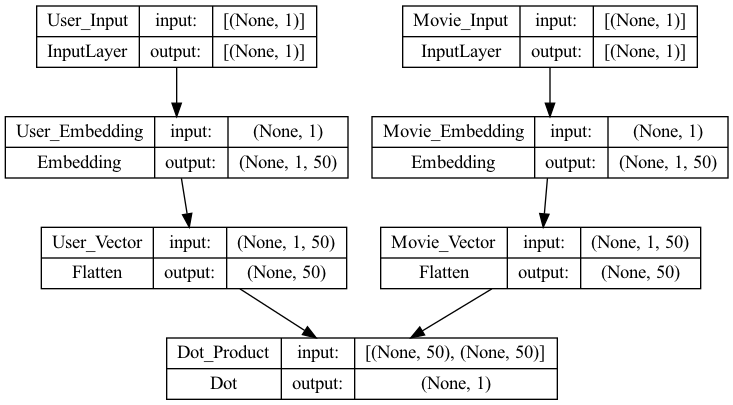

In [58]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [59]:
# SVG(model_to_dot( model,  show_shapes=True, 
#                  show_layer_names=True).create(prog='dot', format='svg'))

In [60]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User_Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Movie_Input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 User_Embedding (Embedding)     (None, 1, 50)        30500       ['User_Input[0][0]']             
                                                                                                  
 Movie_Embedding (Embedding)    (None, 1, 50)        486200      ['Movie_Input[0][0]']            
                                                                                            

another comparison metric: number of parameters (relevant to computational complexity)
- batch size
- epoch
- number of layers for the second DL model
- number of latent variables


In [61]:
optimizer = Adam(lr = 0.0005)

model.compile(loss='mean_squared_error', optimizer = optimizer)

In [62]:
batch_size = 128
epochs = 20

# Start tracking memory before training
print("Memory usage before training:")
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage: {current / 10**6:.2f} MB; Peak: {peak / 10**6:.2f} MB")


Memory usage before training:
Current memory usage: 0.51 MB; Peak: 0.61 MB


In [63]:
# fitting the model
history = model.fit(x=[x_train['userId'], x_train['movieId']], y=y_train, batch_size= batch_size, epochs=epochs, 
                    verbose= 2, validation_data=([x_test['userId'], x_test['movieId']], y_test))


# Capture memory usage after training
print("Memory usage after training:")
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage: {current / 10**6:.2f} MB; Peak: {peak / 10**6:.2f} MB")

# Stop tracemalloc
tracemalloc.stop()

# time: 31.3s

Epoch 1/20
631/631 - 3s - loss: 13.3248 - val_loss: 12.9026 - 3s/epoch - 4ms/step
Epoch 2/20
631/631 - 2s - loss: 10.2334 - val_loss: 6.4094 - 2s/epoch - 3ms/step
Epoch 3/20
631/631 - 2s - loss: 4.1808 - val_loss: 3.0877 - 2s/epoch - 3ms/step
Epoch 4/20
631/631 - 2s - loss: 2.3105 - val_loss: 2.2114 - 2s/epoch - 3ms/step
Epoch 5/20
631/631 - 2s - loss: 1.6368 - val_loss: 1.8062 - 2s/epoch - 4ms/step
Epoch 6/20
631/631 - 2s - loss: 1.2873 - val_loss: 1.5810 - 2s/epoch - 4ms/step
Epoch 7/20
631/631 - 2s - loss: 1.0745 - val_loss: 1.4477 - 2s/epoch - 3ms/step
Epoch 8/20
631/631 - 2s - loss: 0.9338 - val_loss: 1.3630 - 2s/epoch - 3ms/step
Epoch 9/20
631/631 - 2s - loss: 0.8344 - val_loss: 1.3089 - 2s/epoch - 4ms/step
Epoch 10/20
631/631 - 2s - loss: 0.7620 - val_loss: 1.2709 - 2s/epoch - 4ms/step
Epoch 11/20
631/631 - 2s - loss: 0.7060 - val_loss: 1.2472 - 2s/epoch - 3ms/step
Epoch 12/20
631/631 - 2s - loss: 0.6617 - val_loss: 1.2297 - 2s/epoch - 3ms/step
Epoch 13/20
631/631 - 2s - loss: 0

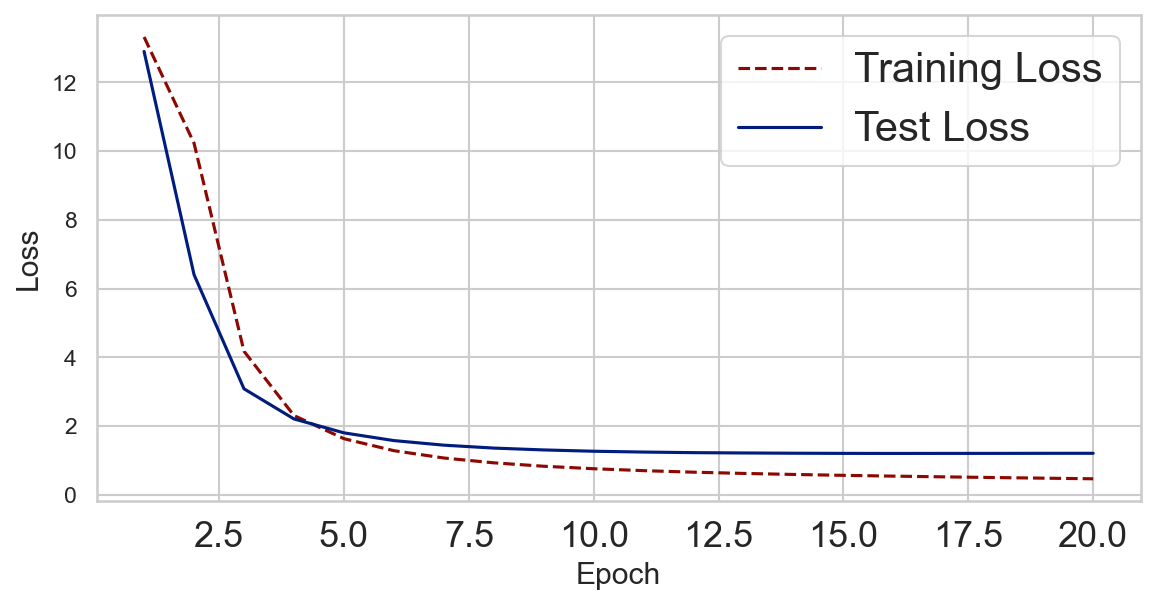

In [64]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [65]:
score = model.evaluate([x_test['userId'], x_test['movieId']], y_test)
print()
print('RMSE: {:.4f}'.format(np.sqrt(score)))

631/631 [==============================] - 0s 409us/step - loss: 1.2112

RMSE: 1.1006


#### Architecture 2

Architecture:

- Combines Embeddings Using Concatenation: The user and movie embeddings are concatenated into a single vector, retaining all latent factors from both embeddings.

- Additional Dense Layers: The concatenated vector is passed through one or more dense layers with non-linear activations (e.g., ReLU), allowing the model to learn more complex interactions.

Interpretation:

- By concatenating the embeddings, the model allows for more expressive feature interactions beyond simple similarity.
Dense layers introduce non-linearity and model higher-order relationships between user and movie embeddings.

Use Case:

- Suitable for content-based filtering or hybrid recommendation systems, where richer interactions or non-linear patterns are required.
- Can capture complex relationships (e.g., multi-level dependencies) at the cost of increased complexity and potential overfitting.

In [66]:
# Start tracemalloc
tracemalloc.start()

# User Embeddings
user_input = Input(shape=(1,), name='User_Input')
user_embeddings = Embedding(input_dim = n_users, output_dim=n_latent_factors, input_length=1, 
                              name='User_Embedding') (user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)



# Movie Embeddings
movie_input = Input(shape=(1,), name='Movie_Input')
movie_embeddings = Embedding(input_dim = n_movies, output_dim=n_latent_factors, input_length=1, 
                               name='Movie_Embedding') (movie_input)
movie_vector = Flatten(name='Movie_Vector') (movie_embeddings)




# Concatenate Product
merged_vectors = concatenate([user_vector, movie_vector], name='Concantenate')
dense_layer_1 = Dense(100, activation='relu')(merged_vectors) 
# dense_layer_1 = Dropout(0.25) (dense_layer_1)
# batchnorm_layer_1 = BatchNormalization()(dense_layer_1)
# dense_layer_2 = Dense(64, activation='relu')(merged_vectors)


result = Dense(1)(dense_layer_1)
model = Model([user_input, movie_input], result)

In [67]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User_Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Movie_Input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 User_Embedding (Embedding)     (None, 1, 50)        30500       ['User_Input[0][0]']             
                                                                                                  
 Movie_Embedding (Embedding)    (None, 1, 50)        486200      ['Movie_Input[0][0]']            
                                                                                            

In [68]:
optimizer = Adam(lr=0.0002)

In [69]:
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [70]:
batch_size = 128
epochs = 20

# Start tracking memory before training
print("Memory usage before training:")
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage: {current / 10**6:.2f} MB; Peak: {peak / 10**6:.2f} MB")


Memory usage before training:
Current memory usage: 0.28 MB; Peak: 0.30 MB


In [71]:
history = model.fit(x=[x_train['userId'], x_train['movieId']], y=y_train, batch_size= batch_size, epochs=epochs, 
                    verbose= 2, validation_data=([x_test['userId'], x_test['movieId']], y_test))

# Capture memory usage after training
print("Memory usage after training:")
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage: {current / 10**6:.2f} MB; Peak: {peak / 10**6:.2f} MB")

# Stop tracemalloc
tracemalloc.stop()

# 39.6s

Epoch 1/20
631/631 - 3s - loss: 4.7213 - val_loss: 0.9219 - 3s/epoch - 4ms/step
Epoch 2/20
631/631 - 2s - loss: 0.7954 - val_loss: 0.7839 - 2s/epoch - 3ms/step
Epoch 3/20
631/631 - 2s - loss: 0.7092 - val_loss: 0.7681 - 2s/epoch - 3ms/step
Epoch 4/20
631/631 - 2s - loss: 0.6823 - val_loss: 0.7675 - 2s/epoch - 4ms/step
Epoch 5/20
631/631 - 2s - loss: 0.6692 - val_loss: 0.7710 - 2s/epoch - 3ms/step
Epoch 6/20
631/631 - 2s - loss: 0.6614 - val_loss: 0.7701 - 2s/epoch - 3ms/step
Epoch 7/20
631/631 - 2s - loss: 0.6559 - val_loss: 0.7741 - 2s/epoch - 3ms/step
Epoch 8/20
631/631 - 2s - loss: 0.6523 - val_loss: 0.7738 - 2s/epoch - 3ms/step
Epoch 9/20
631/631 - 2s - loss: 0.6489 - val_loss: 0.7769 - 2s/epoch - 4ms/step
Epoch 10/20
631/631 - 2s - loss: 0.6465 - val_loss: 0.7795 - 2s/epoch - 4ms/step
Epoch 11/20
631/631 - 2s - loss: 0.6444 - val_loss: 0.7803 - 2s/epoch - 4ms/step
Epoch 12/20
631/631 - 2s - loss: 0.6419 - val_loss: 0.7766 - 2s/epoch - 3ms/step
Epoch 13/20
631/631 - 2s - loss: 0.63

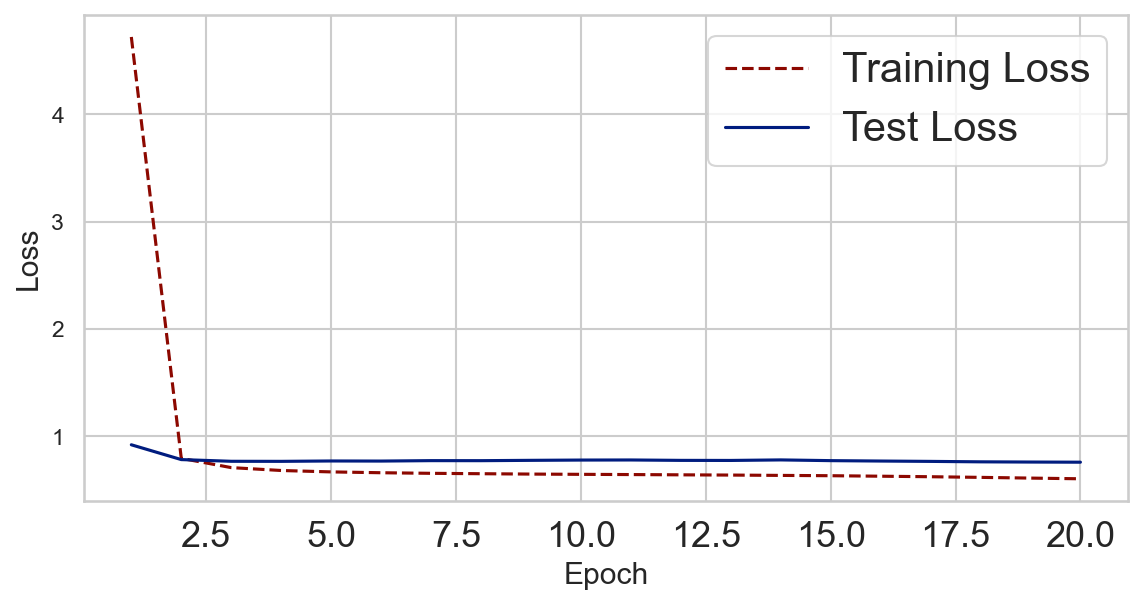

In [72]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [73]:
score = model.evaluate([x_test['userId'], x_test['movieId']], y_test)

print()
print('RMSE: {:.4f}'.format(np.sqrt(score)))

631/631 [==============================] - 0s 460us/step - loss: 0.7596

RMSE: 0.8716


## Result Plotting

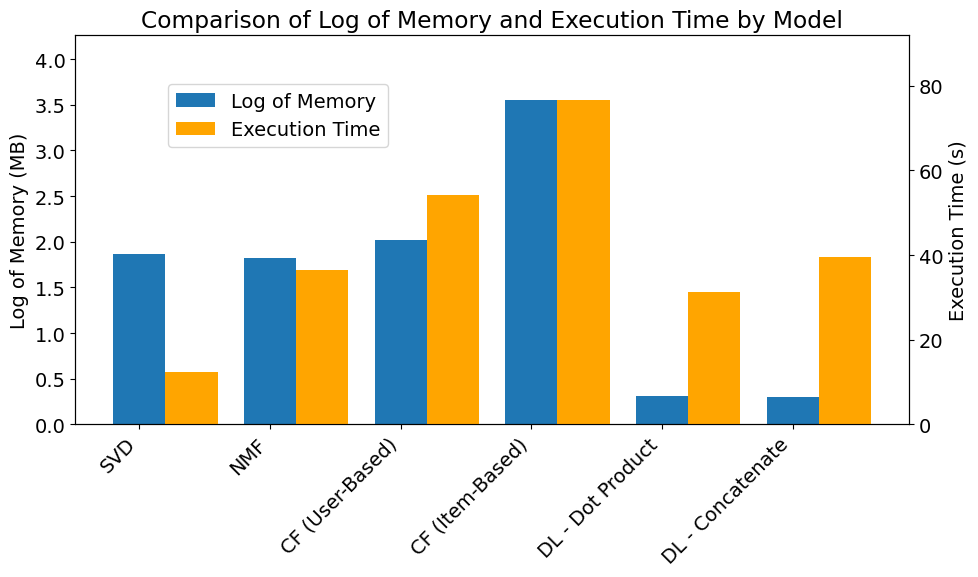

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
data = {
    "Model": [
        "SVD", "NMF", "CF (User-Based)", "CF (Item-Based)", 
        "DL - Dot Product", "DL - Concatenate"
    ],
    "Log Memory": [1.86284666, 1.825880299, 2.020527012, 3.549328248, 0.311753861, 0.301029996],
    "Execution Time (s)": [12.4, 36.5, 54.2, 76.6, 31.3, 39.6]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Set font size globally (optional)
plt.rcParams.update({'font.size': 14})

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar positions
x = range(len(df["Model"]))

# Plotting Log Memory
ax1.bar(x, df["Log Memory"], width=0.4, label="Log of Memory", align="center")
ax1.set_ylabel("Log of Memory (MB)", color="black")
ax1.set_ylim(0, max(df["Log Memory"]) * 1.2)
ax1.set_xticks(x)
ax1.set_xticklabels(df["Model"], rotation=45, ha="right")

# Adding secondary axis for Execution Time
ax2 = ax1.twinx()
ax2.bar([p + 0.4 for p in x], df["Execution Time (s)"], width=0.4, color="orange", label="Execution Time")
ax2.set_ylabel("Execution Time (s)", color="black")
ax2.set_ylim(0, max(df["Execution Time (s)"]) * 1.2)

# Title and legend
plt.title("Comparison of Log of Memory and Execution Time by Model")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)

plt.tight_layout()
plt.show()


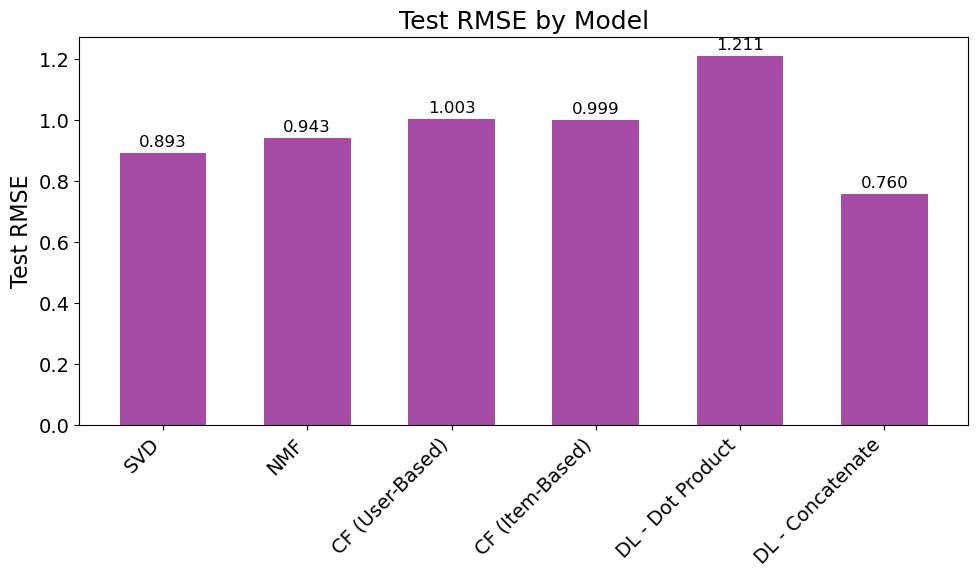

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for Test RMSE
data_rmse = {
    "Model": [
        "SVD", "NMF", "CF (User-Based)", "CF (Item-Based)", 
        "DL - Dot Product", "DL - Concatenate"
    ],
    "Test RMSE": [0.8931, 0.9428, 1.003, 0.9994, 1.2112, 0.7596]
}

# Convert to DataFrame
df_rmse = pd.DataFrame(data_rmse)

# Plot
plt.figure(figsize=(10, 6))
x = range(len(df_rmse["Model"]))

# Bar plot for Test RMSE
plt.bar(x, df_rmse["Test RMSE"], color="purple", alpha=0.7, width=0.6)

# Add labels and title with increased font size
plt.xticks(x, df_rmse["Model"], rotation=45, ha="right", fontsize=14)
plt.ylabel("Test RMSE", fontsize=16)
plt.title("Test RMSE by Model", fontsize=18)

# Add value annotations on top of each bar
for i, value in enumerate(df_rmse["Test RMSE"]):
    plt.text(i, value + 0.02, f"{value:.3f}", ha="center", fontsize=12)

plt.tight_layout()
plt.show()
